In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# !conda install catboost
# !conda install xgboost
# !conda install lightgbm

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [6]:
df = pd.read_csv("datasets/diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

# Random Forests

In [8]:
rf_model = RandomForestClassifier(random_state=17)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [10]:
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.753896103896104
Test F1: 0.6190701534636385
Test AUC: 0.8233960113960114


In [13]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "sqrt"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

In [14]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [15]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [16]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [17]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.766848940533151
Test F1: 0.6447777811143756
Test AUC: 0.8271054131054132


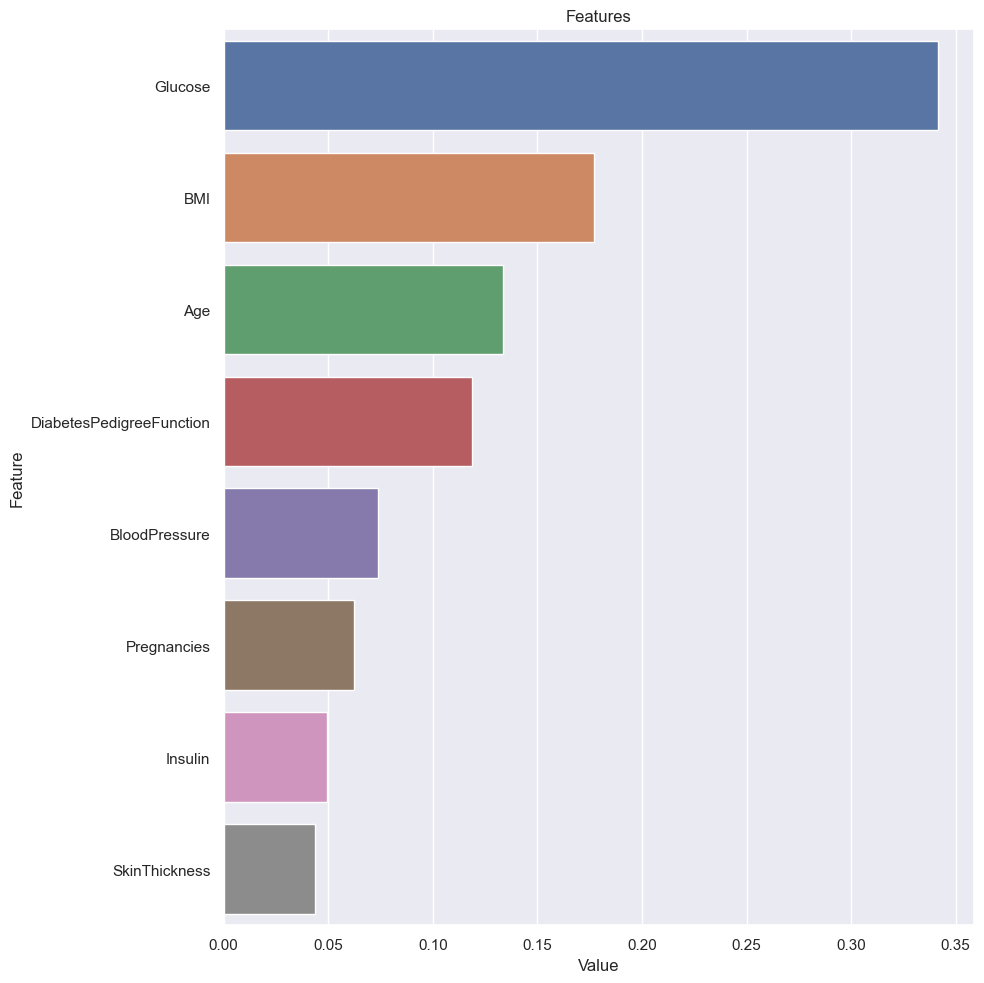

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)

In [19]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

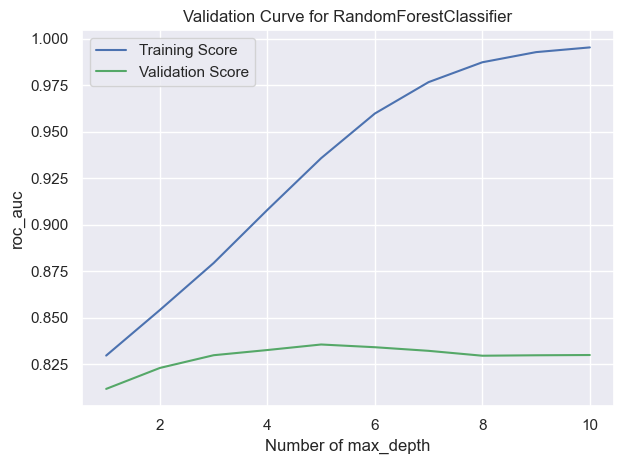

In [20]:
val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="roc_auc")

### GBM

In [23]:
gbm_model = GradientBoostingClassifier(random_state=17)

gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [24]:
cv_results = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7591715474068416
Test F1: 0.634235802826363
Test AUC: 0.8254867225716283


In [25]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

In [26]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [27]:
gbm_best_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}

In [28]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)

In [29]:
cv_results = cross_validate(gbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7760801290213054
Test F1: 0.6657858739532245
Test AUC: 0.8345709294199859


### XGBoost

In [88]:
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 17,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [90]:
cv_results = cross_validate(xgboost_model, X, y,
                            cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [91]:
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7526525761819879
Test F1: 0.6317893713482235
Test AUC: 0.7987134870719776


In [53]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

In [ ]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

In [92]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 100}

In [93]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

In [94]:
cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [65]:
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7591970121381886
Test F1: 0.6062693790510655
Test AUC: 0.8247127882599582


# LightGBM

In [67]:
lgbm_model = LGBMClassifier(random_state=17)
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [68]:
cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [69]:
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7474492827434004
Test F1: 0.624110522144179
Test AUC: 0.7990293501048218


In [70]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

In [72]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [73]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

In [74]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7643578643578645
Test F1: 0.6372062920577772
Test AUC: 0.8147491264849755


In [75]:
# Hiperparametre yeni değerlerle
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

In [76]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [77]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

In [78]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7643833290892115
Test F1: 0.6193071162618689
Test AUC: 0.8227931516422082


In [79]:
# Hiperparametre optimizasyonu sadece n_estimators için.
lgbm_model = LGBMClassifier(random_state=17, colsample_bytree=0.9, learning_rate=0.01)

In [80]:
lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [81]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

In [82]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7643833290892115
Test F1: 0.6193071162618689
Test AUC: 0.8227931516422082


# CatBoost

In [95]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

In [96]:
cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [97]:
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7735251676428148
Test F1: 0.6502723851348231
Test AUC: 0.8378923829489867


In [98]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [99]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [100]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

In [101]:
cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7695611577964518
Test F1: 0.6308243414435932
Test AUC: 0.8428623340321453


# Feature Importance

In [108]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title(f'{model}, Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

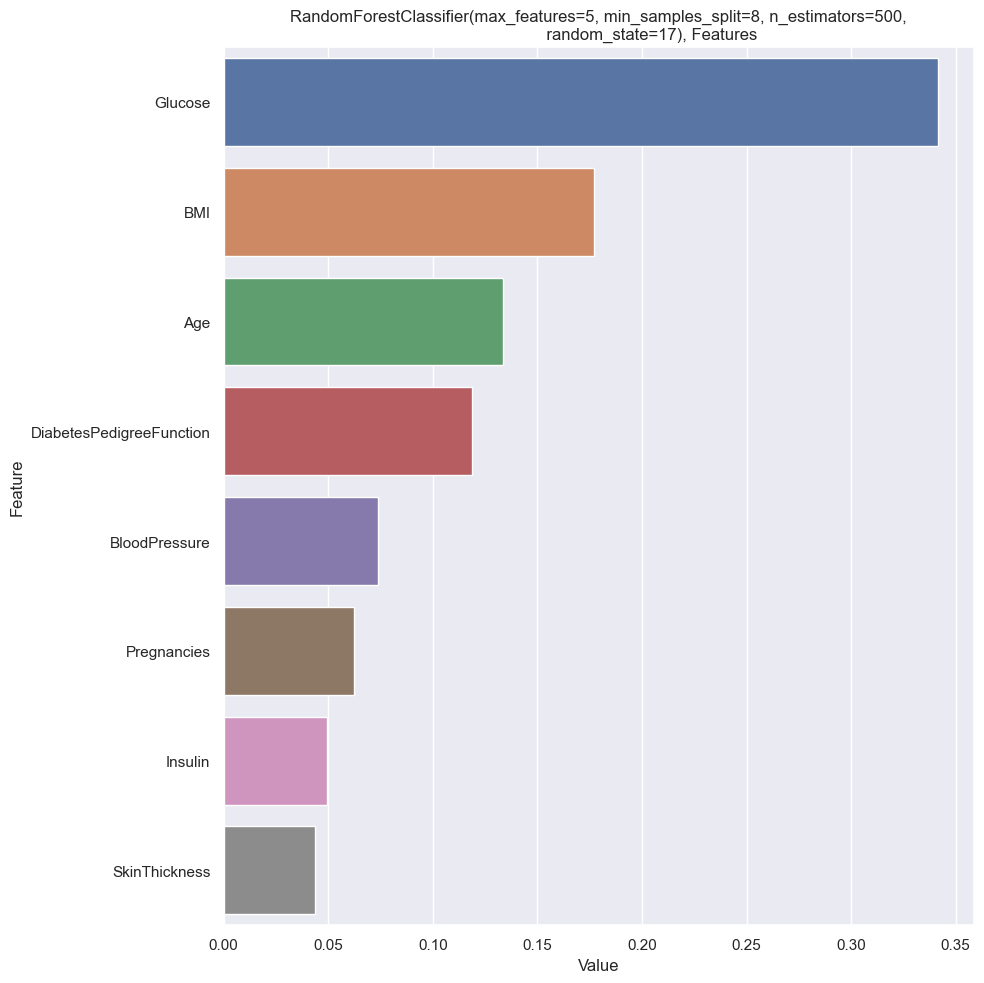

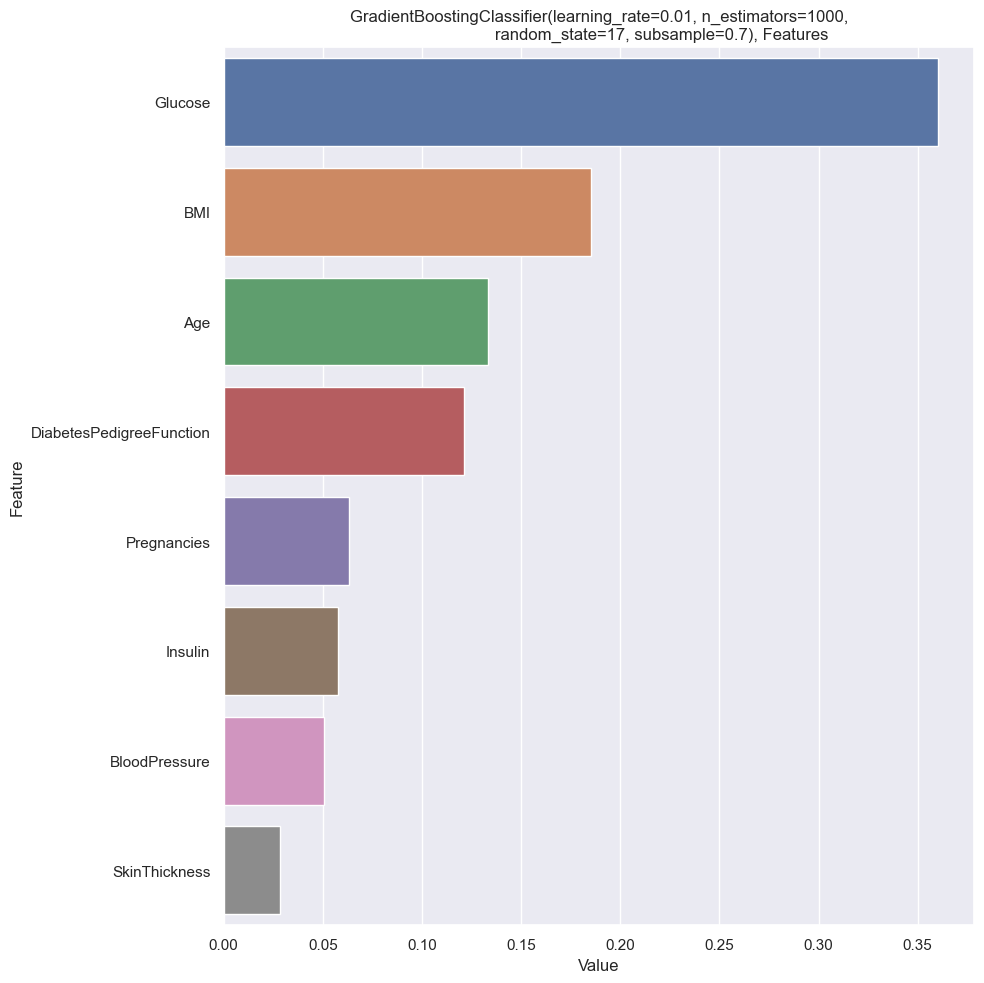

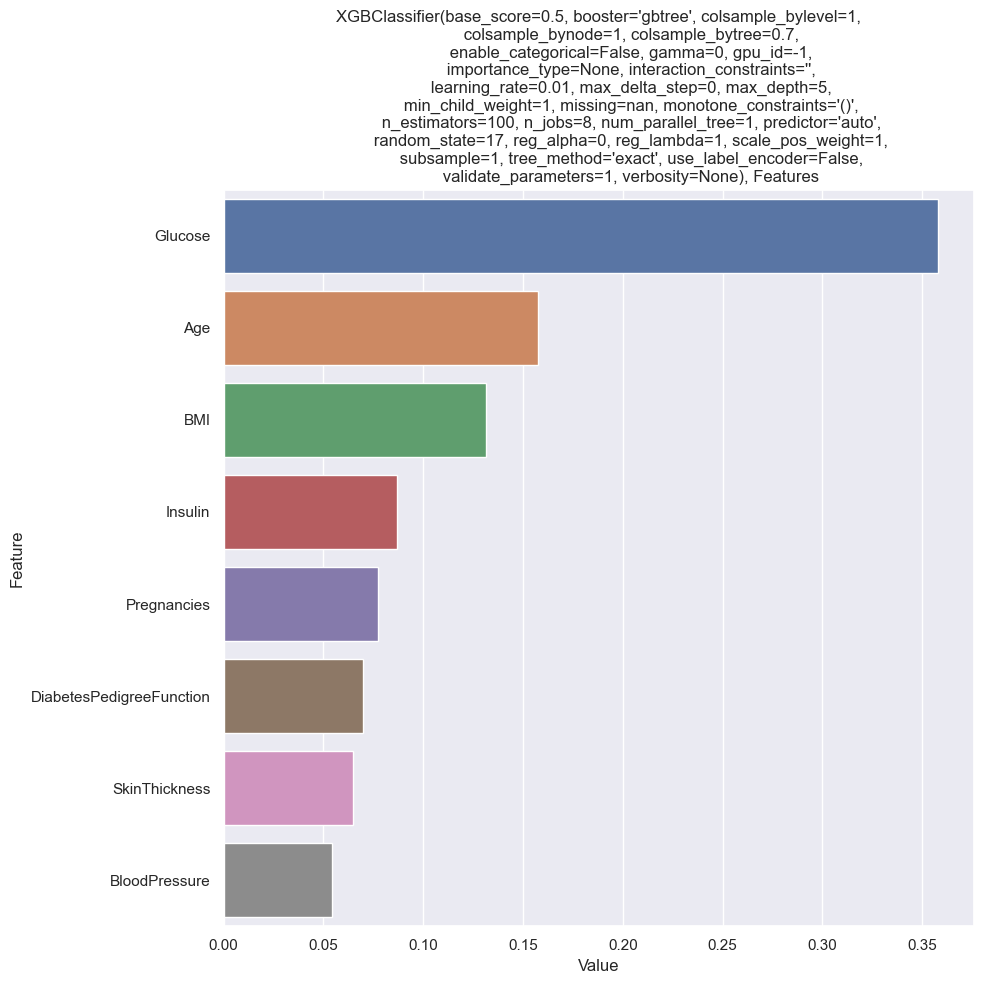

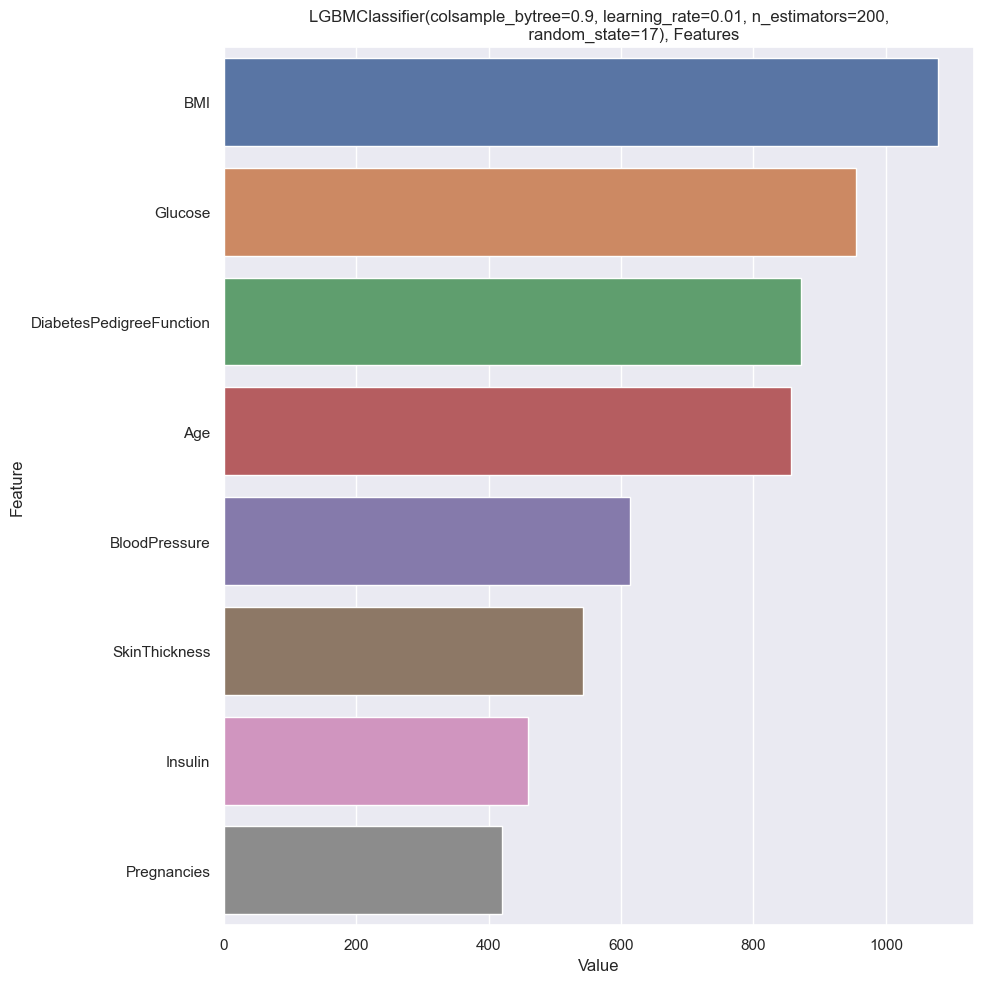

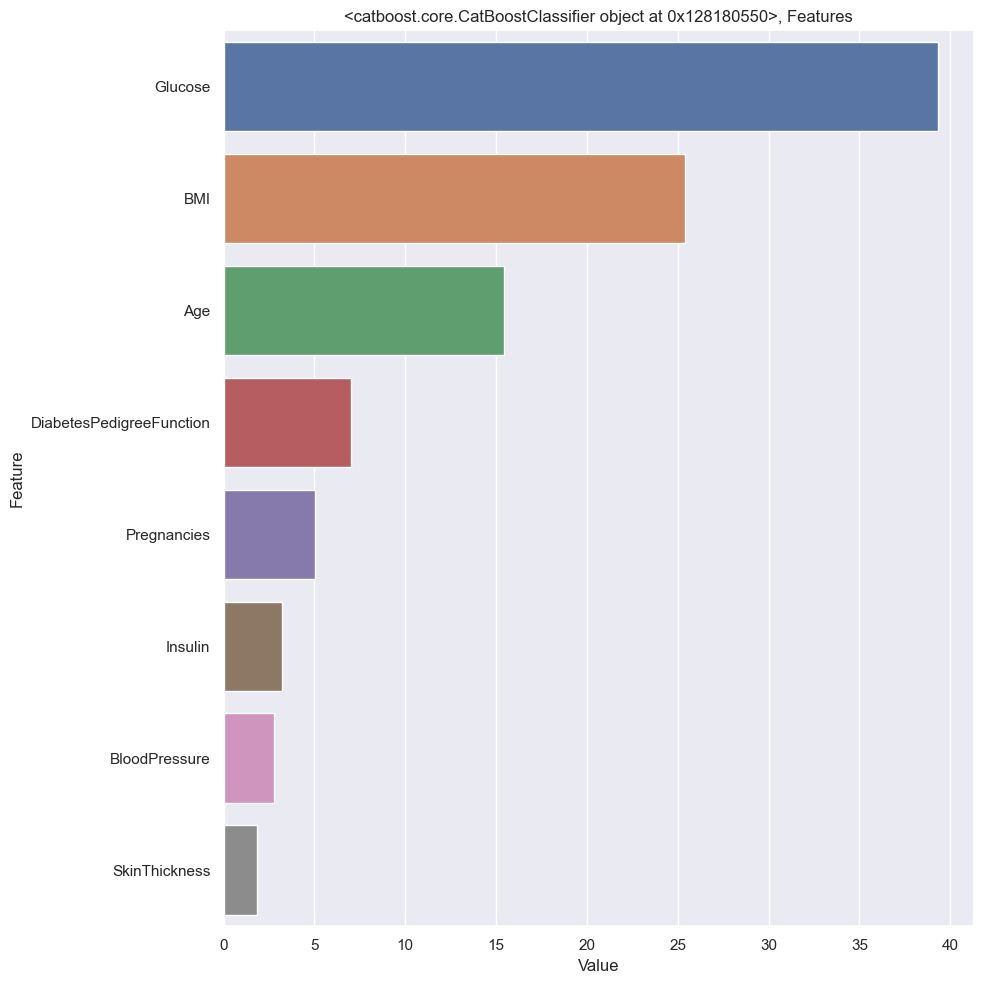

In [109]:
plot_importance(rf_final, X)
plot_importance(gbm_final, X)
plot_importance(xgboost_final, X)
plot_importance(lgbm_final, X)
plot_importance(catboost_final, X)

# Hyperparameter Optimization with RandomSearchCV

In [114]:
rf_model = RandomForestClassifier(random_state=17)

rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([48, 24, 46, 26, 27, 49, 19, 17, 23, 42]),
                                        'max_features': [3, 5, 7, 'sqrt'],
                                        'min_samples_split': array([47, 20, 30, 33, 18, 28, 32, 37, 23, 48, 43, 33,  7, 11, 22, 17, 38,
        2,  5, 40]),
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=True)

In [115]:
rf_random_final = rf_model.set_params(**rf_random.best_params_, random_state=17).fit(X, y)

In [116]:
cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print('Test Acc:', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test AUC:', cv_results['test_roc_auc'].mean())

Test Acc: 0.7695611577964518
Test F1: 0.6308243414435932
Test AUC: 0.8428623340321453


# Analyzing Model Complexity with Learning Curves 

In [117]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

In [118]:
rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]

In [119]:
rf_model = RandomForestClassifier(random_state=17)

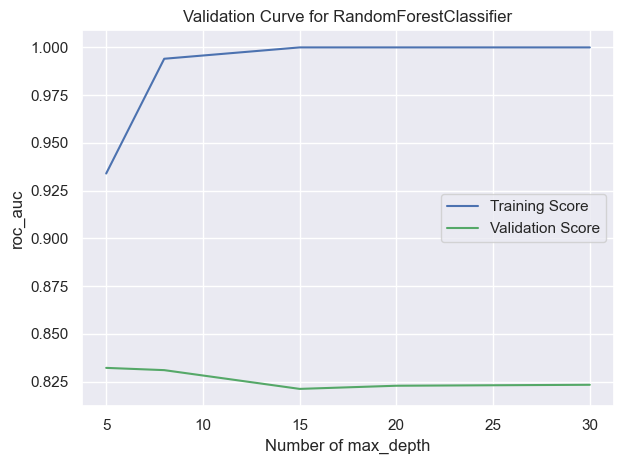

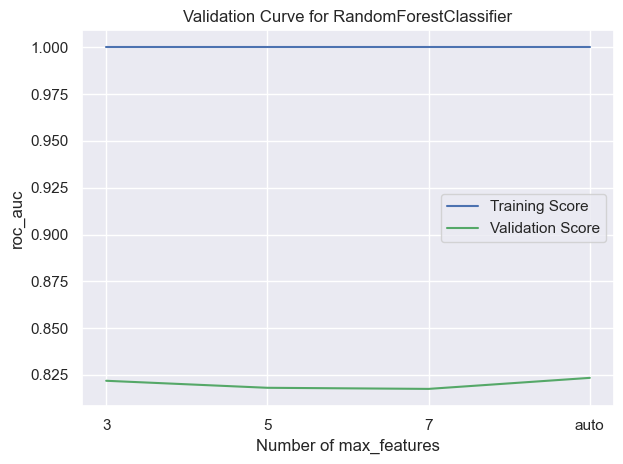

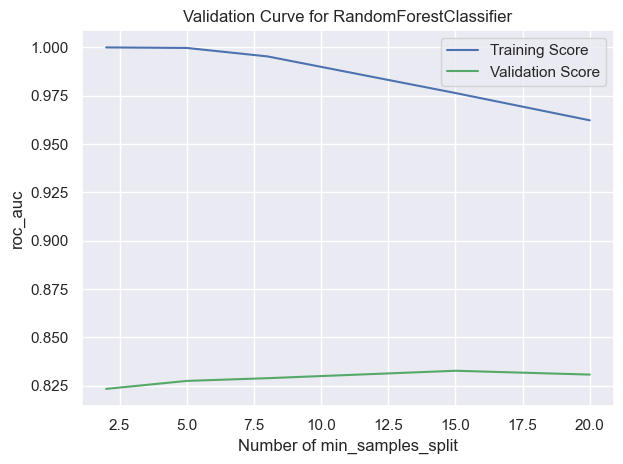

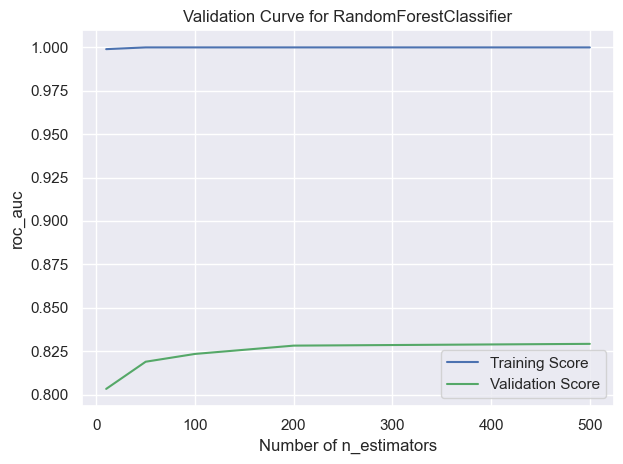

[5, 8, 15, 20, 30, None]

In [120]:
for i in range(len(rf_val_params)):
    val_curve_params(rf_model, X, y, rf_val_params[i][0], rf_val_params[i][1])

rf_val_params[0][1]